In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import erfc

In [2]:
# Class voor de linear congruential method
class LinearCongruential:
    def __init__(self, seed):
        self.seed = seed

    def getRandomNumber(self):
        # Return random number met de "linear congruential method"

        # We proberen hier de seed te randomizen
        seed_copy = self.seed * 2431
        for i in range(5):
            seed_copy = seed_copy * 3 ** 0.25
        seed_copy = self.linear_congruental(seed_copy, 1, 1, 10000)
        return seed_copy

    def linear_congruental(self, x0, a, c, m):
        return int(a * x0 * c % m)

In [3]:
# Class voor de middle square method
class MiddleSquare:
    def __init__(self, seed):
        self.seed = seed

    def getRandomNumber(self):
        # Gemaakt met behulp van: https://en.wikipedia.org/wiki/Middle-square_method

        # De seed moet een even number zijn, dus hier maken we het even.
        number = self.seed
        already_seen = set()

        while number not in already_seen:
            already_seen.add(number)
            number = int(str(number * number).zfill(8)[2:6])
        return number

In [4]:
# Class voor de LaggedFibonacci
class LaggedFibonacci:
    def __init__(self, seed):
        # seed moet ten minste 7 nummers lang zijn.
        self.seed = list(str(seed + 1000000))[:7]
        self.mod = 10001

        # Bepaal welke twee cijfers we pakken van de lijst
        # In dit geval pakken we de 3rde en 7de element van de lijst.
        self.j = 3
        self.k = 7

    def getRandomNumber(self):
        seed = self.seed
        for i in range(40):

            # We pakken de element j en k van de lijst en plakken die dan achter seed.
            number = (int(seed[self.j-1]) + int(seed[self.k-1])) % self.mod
            seed.append(str(number))

            # Daarna halen we de eerste cijfer weg uit de lijst
            seed = seed[1:]
        return number

In [5]:
class MonteCarloSimulation:
    def __init__(self, kansen_tabel, method, n=1000, m=1):
        # We maken hier een dataframe om bij te houden hoe vaak iemand een competitie heeft gewonnen
        self.board = pd.DataFrame(np.zeros((5, 5)))
        self.board.columns = ['Ayax', 'Feyenoord', 'PSV', 'FC Utrecht', 'Willem II']
        self.board.index = ['1ste pos', '2nd pos', '3rd pos', '4th pos', '5th pos']

        # Hou bij hoe vaak we de simulatie moeten doen, standaard is het 1000
        self.n = n

        # Dit bepaalt hoe vaak de teams tegen elkaar spelen in een competitie. Standaard is het maar 1 keer
        self.m = m

        self.kansen_tabel = kansen_tabel
        self.method = method

    def speel(self, kansentabel, n, seed):
        # Functie om een competitie uit te voeren.
        kansen_copy = np.zeros_like(kansentabel)

        # Hier maken we een copy van de kansentabel en vullen we alles met een [0, 0, 0] of 0
        for x in range(kansentabel.shape[0]):
            for y in range(kansentabel.shape[1]):
                if kansentabel[x, y] != [0]:
                    kansen_copy[x, y] = [0, 0, 0]
                else:
                    kansen_copy[x, y] = 0
        
        # Hier bepalen we wie wint.
        while n != 0:
            # We lopen door alles heen en bepalen wie wint gebaseerd op de random number generator die gekozen was.
            for x in range(kansentabel.shape[0]):
                for y in range(kansentabel.shape[1]):
                    # Als de inhoud niet 0 is dan maken we een random number generator aan.
                    if kansentabel[x, y] != [0]:
                        seed += n
                        randomGen = self.method(seed)
                        randomKans = randomGen.getRandomNumber()
                        # De random number generators kunnen maximaal 10000 returnen.
                        # Als de random getal kleiner is dan de eerste waarde * 100, dan heeft hij gewonnen.
                        if randomKans < kansentabel[x, y][0] * 100:
                            kansen_copy[x, y][0] += 1
                        # Als de random getal kleiner is dan de eerste waarde * 100 EN de tweede waarde * 100, 
                        # dan is het gelijkspel
                        elif randomKans < kansentabel[x, y][0] * 100 + kansentabel[x, y][1] * 100:
                            kansen_copy[x, y][1] += 1
                        # Anders heeft hij verloren.
                        else:
                            kansen_copy[x, y][2] += 1
            n -= 1
        return kansen_copy

    def simulation(self):
        # Functie voor het uitvoeren van de simulatie
        for i in range(1, self.n + 1):
            
            # Hier voeren we één competitie uit.
            uitkomsten = self.speel(self.kansen_tabel, self.m, i)

            # Voeg de uitkomsten toe aan de clubs.
            ayax, feyenoord, psv, fc_utrecht, willem_ii = [], [], [], [], []
            for y in range(uitkomsten.shape[1]):
                ayax.append(uitkomsten[0, y])
                feyenoord.append(uitkomsten[1, y])
                psv.append(uitkomsten[2, y])
                fc_utrecht.append(uitkomsten[3, y])
                willem_ii.append(uitkomsten[4, y])
                    
            uitkomsten_pd = pd.DataFrame({'Ayax': ayax, 'Feyenoord':feyenoord, 'PSV':psv, 'FC Utrecht':fc_utrecht, 'Willem II':willem_ii})
            uitkomsten_pd.index = ['Ayax', 'Feyenoord', 'PSV', 'FC Utrecht', 'Willem II']
            punten = {}

            # Voeg hier punten toe aan de teams. 3 punten voor een win, 1 punt voor gelijkspel.
            for row in uitkomsten_pd:
                index = 0
                score = 0
                for y in range(uitkomsten_pd.shape[1]):
                    if uitkomsten_pd[f'{row}'][y] != 0 and uitkomsten_pd.iloc[index][y] != 0:
                        score += uitkomsten_pd[f'{row}'][y][2] * 3 + uitkomsten_pd[f'{row}'][y][1]
                        score += uitkomsten_pd.iloc[index][y][0] * 3 + uitkomsten_pd.iloc[index][y][1]
                punten[row] = score
                index += 1

            # We sorteren hier de lijst, zodat de clubs met de meeste punten vooraan staan
            sorted_score = dict(sorted(punten.items(), key=lambda item: item[1], reverse=True))

            # Hier voegen we hun punten toe aan het boord
            index = 0
            for key in sorted_score.keys():
                self.board[key][index] += 1
                index += 1

    def display(self):
        # Maak een copy van het board en verander de integers naar strings met een procent teken.
        board_copy = self.board.copy()
        board_copy /= self.n / 100
        board_copy = board_copy.astype('str')
        board_copy += '%'

        # Print daarna de dataframe.
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            print(board_copy)

In [6]:
# Dit is een tabel van de kansen van de teams.
kansen = np.array([[[0], [30,21,49],[39,22,39],[25,14,61],[17,18,65]],
                  [[65,17,18],[0],[54,22,24],[37,23,40],[20,26,54]],
                  [[54,21,25],[34,24,39],[0],[29,24,47],[23,24,53]],
                  [[74,14,12],[51,22,27],[62,20,18],[0],[37,25,38]],
                  [[78,13,9],[60,21,19],[62,22,16],[52,23,25], [0]]])

# Maak simulatie en geef parameter aantal simulaties.
# Params: Kansen tabel, methode, aantal competities, aantal keren dat teams tegen elkaar spelen in een competitie.
# Huidige methodes: LinearCongruential, MiddleSquare, LaggedFibonacci
simulation = MonteCarloSimulation(kansen, LaggedFibonacci, 1000, 1)

# Voer simulatie uit. Dit kan een tijdje duren gebaseerd op hoeveel simulaties er plaats vindt.
simulation.simulation()

# Laat percentages zien.
simulation.display()

           Ayax Feyenoord    PSV FC Utrecht Willem II
1ste pos  70.4%     10.8%  18.7%       0.1%      0.0%
2nd pos   19.4%     27.3%  27.9%      23.9%      1.5%
3rd pos    7.4%     27.9%  17.8%      25.6%     21.3%
4th pos    2.8%     27.9%  23.2%      18.6%     27.5%
5th pos    0.0%      6.1%  12.4%      31.8%     49.7%


In [7]:
def frequency_test(randomNumbers):
    # Een basic test voor pseudo random number generators.
    # Als p_value groter is dan 0.01, dan kunnen we met 99% zekerheid zeggen, dat het random is.
    ones = 0
    zeros = 0
    for number in randomNumbers:
        binary_number = bin(number)[2:]
        for number_ in binary_number:
            if int(number_) == 1:
                ones += 1
            elif int(number_) == 0:
                zeros += 1
    s_n = ones-zeros
    n = len(randomNumbers)
    s_obs = s_n / n ** 0.5
    p_value = erfc(s_obs * (2**0.5))
    return p_value

In [8]:
lag_fibonacci = []
middle_square = []
linear_congruential = []
for i in range(1000):
    fibonacci_gen = LaggedFibonacci(i)
    lag_fibonacci.append(fibonacci_gen.getRandomNumber())
    middlesquare_gen = MiddleSquare(i)
    middle_square.append(middlesquare_gen.getRandomNumber())
    linearcongruential_gen = LinearCongruential(i)
    linear_congruential.append(linearcongruential_gen.getRandomNumber())

0.0


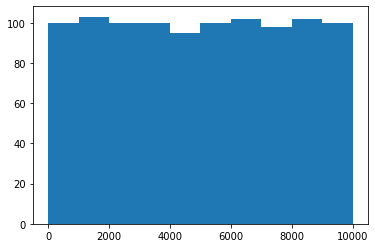

In [9]:
print(frequency_test(lag_fibonacci))
plt.hist(lag_fibonacci)
plt.show()

2.0


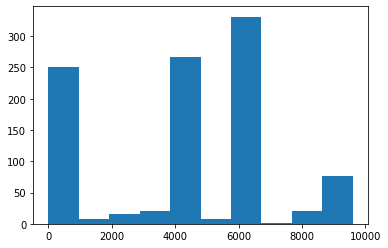

In [10]:
print(frequency_test(middle_square))
plt.hist(middle_square)
plt.show()

5.7583971374738194e-251


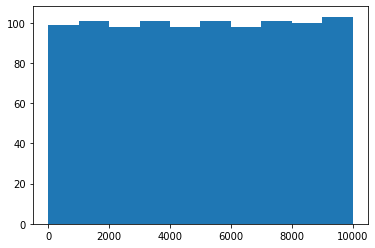

In [11]:
print(frequency_test(linear_congruential))
plt.hist(linear_congruential)
plt.show()